In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Load MNIST
(mnist_X, mnist_y), (mnist_X_, mnist_y_)= tf.keras.datasets.mnist.load_data()

mnist_X = np.reshape(mnist_X,(60000, 28, 28, 1)) / 255
mnist_X = np.tile(mnist_X, (1, 1, 1, 3))
mnist_X = mnist_X.astype('float32')
print(mnist_X.shape)

mnist_X_ = np.reshape(mnist_X_,(10000, 28, 28, 1)) / 255
mnist_X_ = np.tile(mnist_X_, (1, 1, 1, 3))
mnist_X_ = mnist_X_.astype('float32')
print(mnist_X_.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


In [3]:
# Load USPS
with h5py.File('usps.h5', 'r') as hf:
    usps_train = hf.get('train')
    usps_X = usps_train.get('data')[:]
    usps_y = usps_train.get('target')[:]
    usps_test = hf.get('test')
    usps_X_ = usps_test.get('data')[:]
    usps_y_ = usps_test.get('target')[:]

padding = [[0, 0],
           [6, 6],
           [6, 6],
           [0, 0]]

usps_X = np.reshape(usps_X, (-1, 16, 16, 1))
usps_X = np.tile(usps_X, (1,1,1,3))
usps_X = tf.pad(usps_X, padding, 'CONSTANT').numpy()
print(usps_X.shape)

usps_X_ = np.reshape(usps_X_, (-1, 16, 16, 1))
usps_X_ = np.tile(usps_X_, (1,1,1,3))
usps_X_ = tf.pad(usps_X_, padding, 'CONSTANT').numpy()
print(usps_X_.shape)

(7291, 28, 28, 3)
(2007, 28, 28, 3)


MNIST SAMPLE: 3
USPS SAMPLE: 7


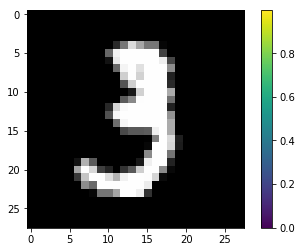

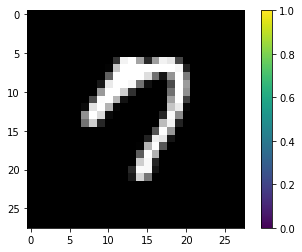

In [4]:
def show_img(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()

print("MNIST SAMPLE: {}".format(mnist_y[10]))
show_img(mnist_X[10])
print("USPS SAMPLE: {}".format(usps_y[10]))
show_img(usps_X[10])

![F2]("./Figure2.png")

### Dataset Details

 - For adaptation between MNIST and USPS, we follow the training protocol established in [21], __sampling 2000 images from MNIST and 1800 from USPS.__

### Model Details

 - our adversarial discriminator consists of 3 fully connected layers: two layers with 500 hidden units followed by the final discriminator output
 - Each of the 500-unit layers uses a ReLU activation function

In [5]:
def LeNetEncoder():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(20, (5, 5),
                        activation='relu',
                        input_shape=(28, 28, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(50, (5, 5),
                        activation='relu',
                        input_shape=(28, 28, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(500,
                           activation='relu'))
    
    return model

In [6]:
def LeNetClassifier():
    model = tf.keras.Sequential()
    model.add(layers.Dropout(0.1,
                             input_shape=(500,)))
    model.add(layers.Dense(10,
                           activation='softmax'))
    
    return model

In [91]:
def Critics():
    model = tf.keras.Sequential()
    model.add(layers.Dense(500,
                           input_shape=(500,),
                           activation='relu'))
    model.add(layers.Dense(500,
                           activation='relu'))
    model.add(layers.Dense(2,
                           activation='softmax'))
    
    return model

In [8]:
source_encoder = LeNetEncoder()
target_encoder = LeNetEncoder()
source_classifier = LeNetClassifier()

In [9]:
trainsets = tf.data.Dataset.from_tensor_slices((mnist_X, mnist_y)).shuffle(buffer_size=mnist_X.shape[0]).batch(64)
testsets = tf.data.Dataset.from_tensor_slices((mnist_X_, mnist_y_)).shuffle(buffer_size=mnist_X_.shape[0]).batch(64)

In [10]:
# pre-train (1) source_encoder, (2) source_classifier
@tf.function
def pretrain_step(X, y):
    with tf.GradientTape() as tape:
        embedding = source_encoder(X)
        pred = source_classifier(embedding)
        loss_value = loss(y, pred)
        
    tvars = source_encoder.trainable_variables + source_classifier.trainable_variables
    grads = tape.gradient(loss_value, tvars)
    opt.apply_gradients(zip(grads, tvars))
    
    return pred, loss_value

In [15]:
loss = keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

In [17]:
for _ in range(5):
    for X, y in trainsets:
        pred, lv = pretrain_step(X, y)
        pred_idx = tf.argmax(pred, axis=1)

        if opt.iterations.numpy() % 100 == 0:
            print("Step:{}, Loss:{:.4}, Accuracy:{:.4}".format(opt.iterations.numpy(),
                                               loss(y, pred),
                                               sum(np.equal(pred_idx.numpy(), y))/len(y)))

Step:100, Loss:0.007728, Accuracy:1.0
Step:200, Loss:0.08876, Accuracy:0.9688
Step:300, Loss:0.08516, Accuracy:0.9688
Step:400, Loss:0.04499, Accuracy:0.9844
Step:500, Loss:0.03746, Accuracy:0.9688
Step:600, Loss:0.083, Accuracy:0.9688
Step:700, Loss:0.1505, Accuracy:0.9531
Step:800, Loss:0.1606, Accuracy:0.9531
Step:900, Loss:0.004078, Accuracy:1.0
Step:1000, Loss:0.06235, Accuracy:0.9688
Step:1100, Loss:0.004179, Accuracy:1.0
Step:1200, Loss:0.09427, Accuracy:0.9688
Step:1300, Loss:0.0185, Accuracy:1.0
Step:1400, Loss:0.09841, Accuracy:0.9844
Step:1500, Loss:0.1463, Accuracy:0.9688
Step:1600, Loss:0.04286, Accuracy:0.9688
Step:1700, Loss:0.06443, Accuracy:0.9844
Step:1800, Loss:0.127, Accuracy:0.9531
Step:1900, Loss:0.1083, Accuracy:0.9844
Step:2000, Loss:0.01185, Accuracy:1.0
Step:2100, Loss:0.008306, Accuracy:1.0
Step:2200, Loss:0.02644, Accuracy:0.9844
Step:2300, Loss:0.1077, Accuracy:0.9531
Step:2400, Loss:0.03503, Accuracy:0.9844
Step:2500, Loss:0.1541, Accuracy:0.9531
Step:2600

In [18]:
def model_eval(model, X, y, metric_loss, metric_acc):
    ebd = model(X)
    prob = source_classifier(ebd)
    lv = loss(y, prob)
    
    metric_loss(lv)
    metric_acc(y, prob)

In [48]:
loss_avg = keras.metrics.Mean()
accuracy = keras.metrics.SparseCategoricalAccuracy()
for X, y in testsets:
    model_eval(source_encoder, X, y, loss_avg, accuracy)
print(loss_avg.result())
print(accuracy.result())

tf.Tensor(0.09228537, shape=(), dtype=float32)
tf.Tensor(0.9804, shape=(), dtype=float32)


In [20]:
source_encoder.save('pre_weights.h5')
target_encoder = keras.models.load_model('pre_weights.h5')
# source_encoder = keras.models.load_model('pre_weights.h5')

W1205 23:40:55.309463 140179095869184 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [49]:
loss_avg = keras.metrics.Mean()
accuracy = keras.metrics.SparseCategoricalAccuracy()
for X, y in testsets:
    model_eval(target_encoder, X, y, loss_avg, accuracy)
print(loss_avg.result())
print(accuracy.result())

tf.Tensor(0.09228537, shape=(), dtype=float32)
tf.Tensor(0.9804, shape=(), dtype=float32)


In [109]:
critic = Critics()
target_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
cce = tf.keras.losses.SparseCategoricalCrossentropy()
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [120]:
@tf.function
def train_others(img_src, img_tgt):
    # discriminator
    with tf.GradientTape() as disc_tape:
        source_ebd = source_encoder(img_src, training=False)
        target_ebd = target_encoder(img_tgt, training=True)
        concat_ebd = tf.concat([source_ebd, target_ebd], 0)

        concat_pred = critic(concat_ebd, training=True)
        
        source_label = tf.ones_like(source_ebd[:, 0])
        target_label = tf.zeros_like(target_ebd[:, 0])
        concat_label = tf.concat([source_label, target_label], 0)
#         tf.reshape(concat_label, (-1,1))
        
        disc_loss = cce(concat_label, concat_pred)

    disc_grads = disc_tape.gradient(disc_loss, critic.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_grads, critic.trainable_variables))
    
    with tf.GradientTape() as tgt_tape:
        target_ebd = target_encoder(img_tgt, training=True)
        target_pred = critic(target_ebd, training=False)
        target_label = tf.ones_like(target_pred[:, 0])
#         tf.reshape(target_label, (-1,1))
        
        target_loss = cce(target_label, target_pred)
        
    target_grads = tgt_tape.gradient(target_loss, target_encoder.trainable_variables)
    target_optimizer.apply_gradients(zip(target_grads, target_encoder.trainable_variables))
    
    return disc_loss, target_loss

In [131]:
source_sets = tf.data.Dataset.from_tensor_slices((mnist_X, mnist_y)).shuffle(buffer_size=mnist_X.shape[0]).batch(64)
target_sets = tf.data.Dataset.from_tensor_slices((usps_X, usps_y)).shuffle(buffer_size=usps_X.shape[0]).batch(64)
test_sets = tf.data.Dataset.from_tensor_slices((usps_X_, usps_y_)).shuffle(buffer_size=usps_X_.shape[0]).batch(64)

In [133]:
dll = []
tll = []
for epoch in range(50):
    for (mx, my), (tx, ty) in zip(source_sets, target_sets):
        dl, tl = train_others(mx, tx)
        dll.append(dl.numpy())
        tll.append(tl.numpy())
        
    loss_avg = keras.metrics.Mean()
    accuracy = keras.metrics.SparseCategoricalAccuracy()
    for X, y in test_sets:
        model_eval(target_encoder, X, y, loss_avg, accuracy)
    print("Epoch:"+str(epoch), end=" => ")
    print(loss_avg.result() , end=" | ")
    print(accuracy.result())
    

Epoch:0 => tf.Tensor(0.46202245, shape=(), dtype=float32) | tf.Tensor(0.88540107, shape=(), dtype=float32)
Epoch:1 => tf.Tensor(0.4638586, shape=(), dtype=float32) | tf.Tensor(0.8888889, shape=(), dtype=float32)
Epoch:2 => tf.Tensor(0.46443993, shape=(), dtype=float32) | tf.Tensor(0.8953662, shape=(), dtype=float32)
Epoch:3 => tf.Tensor(0.47168225, shape=(), dtype=float32) | tf.Tensor(0.9013453, shape=(), dtype=float32)
Epoch:4 => tf.Tensor(0.48840812, shape=(), dtype=float32) | tf.Tensor(0.9003488, shape=(), dtype=float32)
Epoch:5 => tf.Tensor(0.49549234, shape=(), dtype=float32) | tf.Tensor(0.900847, shape=(), dtype=float32)
Epoch:6 => tf.Tensor(0.492898, shape=(), dtype=float32) | tf.Tensor(0.90632784, shape=(), dtype=float32)
Epoch:7 => tf.Tensor(0.49202988, shape=(), dtype=float32) | tf.Tensor(0.90881914, shape=(), dtype=float32)
Epoch:8 => tf.Tensor(0.48391986, shape=(), dtype=float32) | tf.Tensor(0.90632784, shape=(), dtype=float32)
Epoch:9 => tf.Tensor(0.4841591, shape=(), dtyp

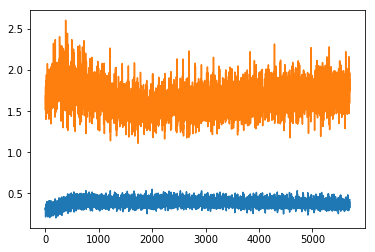

In [134]:
plt.plot(dll)
plt.plot(tll)